## Feature Development Extraction: Neurophysiology [dyskinesia project]




<b> Content </b>


<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)
- aperiodic component, PD severity, and cortico-subcortico-activity, Bush & Zou, Richardson, bioRxiv 2023 https://www.biorxiv.org/content/10.1101/2023.02.08.527719v1?rss=1

<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition





### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt

from scipy import signal, stats
from array import array
import datetime as dt
# #mne
# import mne_bids
import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-kit learn 1.1.3


In [3]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [4]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')

In [6]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_plotting.expl_plotting as expl_plot
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as spectral
import lfpecog_features.feats_spectral_helpers as specHelp


import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
import lfpecog_analysis.get_acc_derivs as accDerivs


from lfpecog_plotting.plotHelpers import remove_duplicate_legend

### 1. Load Merged Sub-Data

In [7]:
os.chdir(codepath)

from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)


load none ephys pickle

In [206]:
subs_to_plot = [
    '008', '009', '010', '012', 
    '013', '014', '016']

data_version = 'v3.1'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    acc = load_class_pickle(os.path.join(
        get_project_path('data'),
        'merged_sub_data', data_version,
        f'{sub}_mergedDataClass_{data_version}_noEphys.P'
    ))
    acc = correct_acc_class(acc)

    mins_recording.append(acc.data.shape[0] / acc.fs / 60)

In [208]:
print(f'Mean minutes of recording were {np.mean(mins_recording)} (+/- {np.std(mins_recording)})')

Mean minutes of recording were 56.82619047619047 (+/- 11.972434798792513)


load ephys pickle

In [10]:
subs_to_plot = [
    # '008', '009', '010', '012', 
    # '013', '014',
    '016',
]
task = 'rest'
data_version = 'v3.1'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    data = load_class_pickle(os.path.join(
        get_project_path('data'), 'windowed_data_classes_60s',
        data_version, f'sub-{sub}', task,
        f'{sub}_mneEpochs_{task}_{data_version}_win60s_overlap0.5.P'
    ))
    # acc = correct_acc_class(acc)


In [27]:
data.list_mne_objects[0].times.shape

data.list_mne_objects[0].ch_names

data.list_mne_objects[0].get_data().shape

(90, 29, 1024)

#### fooof for spectral features

for now decided to use knee-models

´fm_knee = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee', # fixed or knee
    verbose=False,
)`

fm_knee.fit(f, pxx, [4, 148])

params:
- fm_knee.get_results().error  # error of the fit
- fm_knee.get_results().r_squared  # r^2 (goodness) of fit
- fm_knee.get_results().aperiodic_params  # offset, knee, exponent OR offset, exponent
- fm_knee.get_results().peak_params  # 2d array with pro row one peak's [mid-f, power, bandwidth]
- fm_knee.get_results().gaussian_params  # 2d array with Gaussian fits of peaks [mid-f, height, sd]


In [400]:
from fooof import FOOOF

In [538]:
importlib.reload(specHelp)
importlib.reload(spectral)

<module 'lfpecog_features.feats_spectral_features' from 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\code\\lfpecog_features\\feats_spectral_features.py'>

In [255]:
print(data.list_mne_objects[0].ch_names)

['ECOG_R_05_06', 'LFP_L_1a_LAT', 'LFP_L_1b_LAT', 'LFP_L_1c_LAT', 'LFP_L_1a_SUPa', 'LFP_L_1b_SUPa', 'LFP_L_1c_SUPa', 'LFP_L_2a_LAT', 'LFP_L_2b_LAT', 'LFP_L_2c_LAT', 'LFP_L_2a_SUPa', 'LFP_L_2b_SUPa', 'LFP_L_2c_SUPa', 'LFP_R_0a_SUPa', 'LFP_R_0a_SUPb', 'LFP_R_0a_SUPc', 'LFP_R_1a_LAT', 'LFP_R_1b_LAT', 'LFP_R_1c_LAT', 'LFP_R_1a_SUPa', 'LFP_R_1b_SUPa', 'LFP_R_1c_SUPa', 'LFP_R_2a_LAT', 'LFP_R_2b_LAT', 'LFP_R_2c_LAT', 'LFP_R_2a_SUPa', 'LFP_R_2b_SUPa', 'LFP_R_2c_SUPa', 'LFP_R_3a_SUPa']


In [506]:
# FOOOF peak definition -> MODULE

i_win = 3
# ch = 'LFP_R_2b_SUPa'
# i_ch = np.where([name == ch for name in data.list_mne_objects[win_i].ch_names])[0][0]
# ch_wins = data.list_mne_objects[win_i].get_data()[:, i_ch, :]
fs = data.info['sfreq']
nperseg = 1024
fooof_range = [4, 98]  # wider window -> more accurate, more comp-time
bw_ranges = {
    'alpha': [8, 12],
    'lo_beta': [12, 20],
    'hi_beta': [20, 35],
    'midgamma': [60, 90]
}

In [570]:
# get spectral power value per window (60-sec)
win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
chnames = data.list_mne_objects[i_win].ch_names

epoch_feats = {}

for i_ep in np.arange(10, 12):
    epoch_feats[i_ep] = get_fooof_fts_per_epoch(
        epoch_dat=win_dat[i_ep, :, :],
        ch_names=chnames
    )

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value 

{'LFP_L': {'peak_freq': {'alpha': {'mean': 10.501827891955118, 'cv': 0.10109995797532198, 'sd': 1.0617343585407266}, 'lo_beta': {'mean': 16.26318494368539, 'cv': 0.12370820800223789, 'sd': 2.0118894657922954}, 'hi_beta': {'mean': 27.996957814769154, 'cv': 0.14226644255056964, 'sd': 3.9830275905455776}, 'midgamma': {'mean': 74.30221700860395, 'cv': 0.11575002888318787, 'sd': 8.6004837648308}}, 'peak_size': {'alpha': {'mean': 3.4583587264513285, 'cv': 0.6172192142866977, 'sd': 2.1345654558618334}, 'lo_beta': {'mean': 4.12256963411753, 'cv': 0.4451240019775638, 'sd': 1.835054693969576}, 'hi_beta': {'mean': 2.5007347124444683, 'cv': 0.6393476929235419, 'sd': 1.5988389690151878}, 'midgamma': {'mean': 3.73606017305346, 'cv': 0.8532842162540751, 'sd': 3.187921176641986}}, 'ap_off': {'mean': -12.766774769554296, 'cv': -0.3894536745669036, 'sd': 4.972067346370954}, 'ap_exp': {'mean': 1.4741010193385007, 'cv': 1.408349448849437, 'sd': 2.076049358133771}}, 'LFP_R': {'peak_freq': {'alpha': {'mean'

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[] []
{'LFP_L': {'peak_freq': {'alpha': {'mean': 9.513667468464314, 'cv': 0.06083758513477642, 'sd': 0.5787885545566506}, 'lo_beta': {'mean': 15.715003075787155, 'cv': 0.13020295621127764, 'sd': 2.0461398573368084}, 'hi_beta': {'mean': 26.936317653727187, 'cv': 0.14597161367016442, 'sd': 3.9319377542466944}, 'midgamma': {'mean': 75.83263549419001, 'cv': 0.12004635028614186, 'sd': 9.103431123656849}}, 'peak_size': {'alpha': {'mean': 1.7643610779913537, 'cv': 0.9043019804607588, 'sd': 1.5955152170754605}, 'lo_beta': {'mean': 2.402812164668839, 'cv': 0.5206132943762029, 'sd': 1.2509359568154594}, 'hi_beta': {'mean': 3.4688636656642875, 'cv': 0.41301806959682263, 'sd': 1.432703374887222}, 'midgamma': {'mean': 4.057939677976873, 'cv': 0.5261852175320513, 'sd': 2.135227872188203}}, 'ap_off': {'mean': -13.748145964493263, 'cv': -0.16392793088837693, 'sd': 2.25370512151077}, 'ap_exp': {'mean': 0.8650464265793961, 'cv': 0.7154983619301128, 'sd': 0.6189393012110556}}, 'LFP_R': {'peak_freq': {'al

C:\Users\habetsj\AppData\Local\Temp\ipykernel_15456\437178474.py:59: RuntimeWarning: Mean of empty slice
  ft_out[src][ft][bw]['mean'] = np.nanmean(ft_temp[src][ft][bw])
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [569]:
def get_fooof_fts_per_epoch(
    epoch_dat, ch_names,
    sources_incl=['ECOG', 'LFP_L', 'LFP_R'],
):
    """
    extracts aperiodic and spectral peak features
    over 2d array (channels, timepoints)
    """

    ft_out = specHelp.get_empty_spectral_ft_dict(lists_or_means='means')
    # lists to store feats before calculating means, cv, sd, ..
    ft_temp = specHelp.get_empty_spectral_ft_dict(lists_or_means='lists')
    
    for i_ch in np.arange(epoch_dat.shape[0]): # loop over all channels
        chname = ch_names[i_ch]
        skip = True
        # define matching source
        for src in sources_incl:
            if chname.startswith(src):
                source = src
                skip = False
        if skip: continue  # skip channel if not in sources_incl
        # select and transform data from one channel, in one epoch
        f, pxx = signal.welch(
            epoch_dat[i_ch, :], fs=fs, nperseg=nperseg,
        )
        # correct psd shape for linenoise corrected throughs
        pxx = specHelp.correct_notch_throughs(f, pxx, np.arange(50, 1201, 50))
        # get aperiodic and periodic features
        (
            ap_off, ap_exp, pk_cf, pk_pw
        ) = spectral.get_fooof_peaks_freqs_and_sizes(
            f, pxx, range=fooof_range, knee_or_fix='knee',
        )

        # distribute peaks to feat_arrays based on bandwidths
        if np.isnan(ap_off): print(pk_cf, pk_pw)  # continue ?
        # add aperiodic feats
        ft_temp[source]['ap_off'].append(ap_off)
        ft_temp[source]['ap_exp'].append(ap_exp)
        # add peak-feats per bandwidth
        for bw, rng in zip(bw_ranges.keys(), bw_ranges.values()):
            bw_sel = np.logical_and(rng[0] < pk_cf, pk_cf < rng[1])
            # skip if peak combi not present
            if len(bw_sel) == 0: continue
            # add lists of peak-values to correct list
            ft_temp[source]['peak_freq'][bw].extend(pk_cf[bw_sel])
            ft_temp[source]['peak_size'][bw].extend(pk_pw[bw_sel])

    # convert ft_lists to means per source (and bw)
    for src in sources_incl:
        for ft in ['ap_off', 'ap_exp']:
            ft_out[src][ft]['mean'] = np.nanmean(ft_temp[src][ft])
            ft_out[src][ft]['sd'] = np.nanstd(ft_temp[src][ft])
            ft_out[src][ft]['cv'] = stats.variation(ft_temp[src][ft], nan_policy='omit')     
        
        for ft in ['peak_freq', 'peak_size']:
            for bw in bw_ranges.keys():
                ft_out[src][ft][bw]['mean'] = np.nanmean(ft_temp[src][ft][bw])
                ft_out[src][ft][bw]['sd'] = np.nanstd(ft_temp[src][ft][bw])
                ft_out[src][ft][bw]['cv'] = stats.variation(ft_temp[src][ft][bw], nan_policy='omit')
        
            
    print(ft_out)

    return ft_out
                    

In [472]:
# fm = FOOOF(
#     peak_width_limits=(.5, 5),
#     peak_threshold=.5,
#     aperiodic_mode='knee',
#     verbose=False,
# )

# fm.report(f, pxx, [4, 198])


(4.0, 150.0)

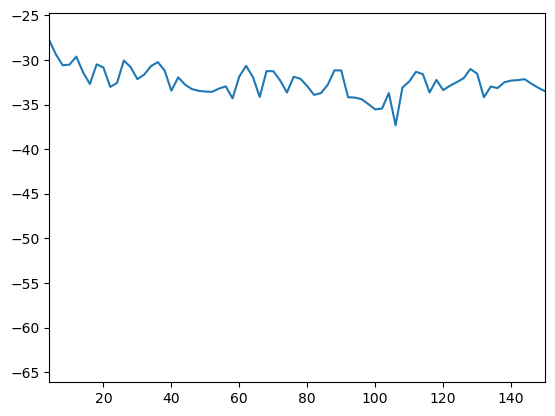

In [473]:
# plt.plot(np.log(f), np.log(pxx))
# plt.xlim(np.log([4, 100]))

plt.plot(f, np.log(pxx))
plt.xlim([4, 150])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 98 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -14.1645, -1.9896, 0.5087                                     
                                                                                                  
                                       13 peaks were found:                                       
          

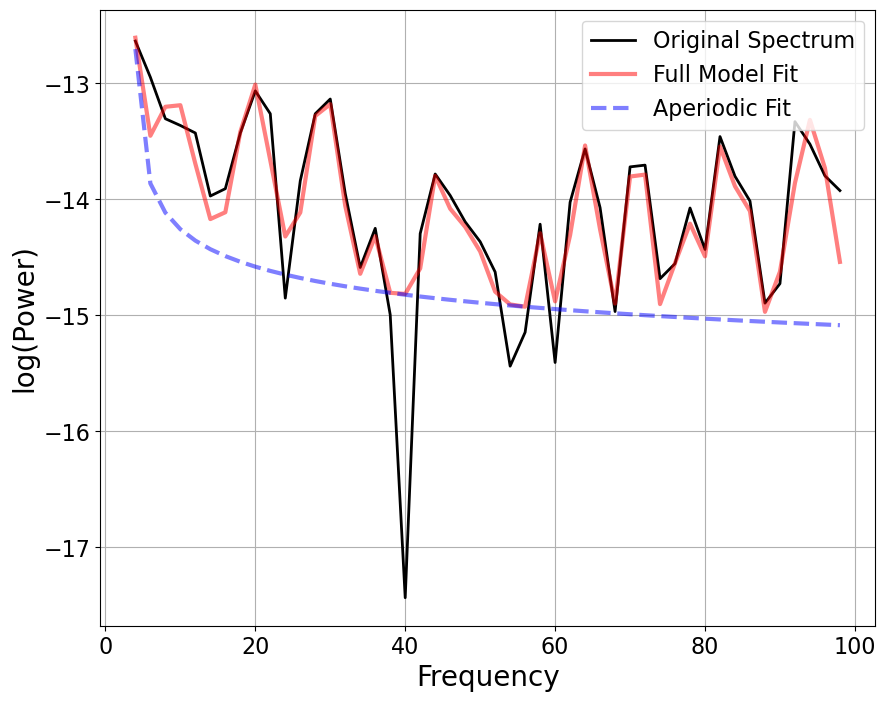

In [460]:
fm_knee.report(f, pxx, [4, 98])


#### test SSD

In [90]:

ch = 'ECOG_R_05_06'
i_ch = np.where([name == ch for name in data.list_mne_objects[0].ch_names])[0][0]
ch_wins = data.list_mne_objects[0].get_data()[:, 0, :]
fs = data.info['sfreq']
nperseg = 1024

In [240]:
chs_incl = np.arange(1, 6)

for n, i_ch in enumerate(chs_incl):
    temp = data.list_mne_objects[0].get_data()[:20:2, i_ch, :].ravel()
    temp = temp.reshape(1, len(temp))

    if n == 0: multi_arr = temp
    else:
        multi_arr = np.concatenate([multi_arr, temp], axis=0)    
multi_arr.shape

(5, 10240)

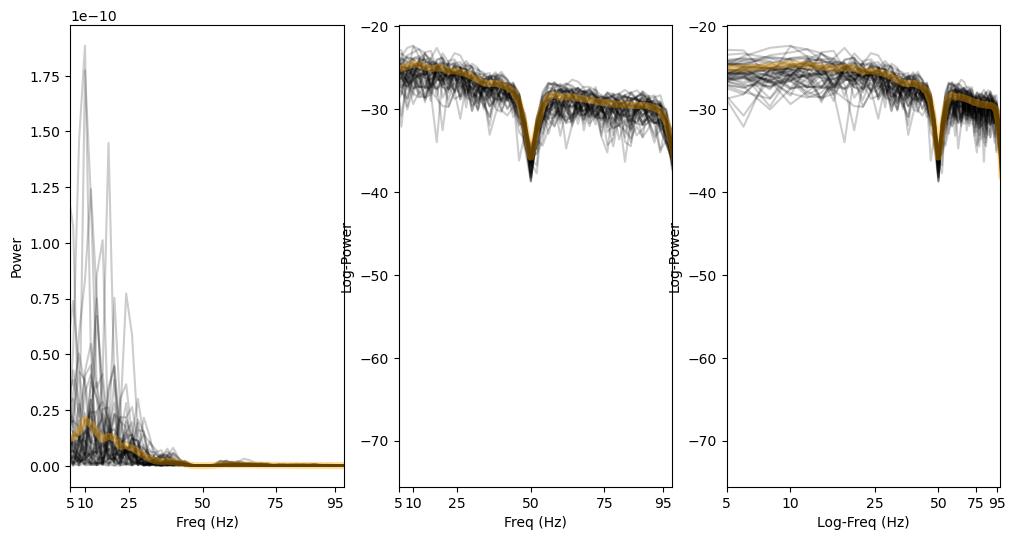

In [252]:

ch = 'ECOG_R_05_06'
i_ch = np.where([name == ch for name in data.list_mne_objects[0].ch_names])[0][0]
ch_wins = data.list_mne_objects[0].get_data()[:, 0, :]
fs = data.info['sfreq']
nperseg = 1024

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
x_see = (5, 98)

xlabels = [1, 5, 10, 25, 50, 75, 95, 200, 400]

for i_win in np.arange(0, 50):

    f, Px = signal.welch(
        ch_wins[i_win, :], fs=fs, nperseg=nperseg,
    )
    f[0] = 1
    # Px = Px[1:]
    axes[0].plot(
        f, Px,
        alpha=.2, color='k',)
    axes[0].set_xlabel('Freq (Hz)')
    axes[0].set_ylabel('Power')
    axes[0].set_xticks(xlabels)
    axes[0].set_xticklabels(xlabels)
    axes[0].set_xlim(x_see)

    axes[1].plot(
        f, np.log(Px),
        alpha=.2, color='k',)
    axes[1].set_xticks(xlabels)
    axes[1].set_xticklabels(xlabels)
    axes[1].set_xlabel('Freq (Hz)')
    axes[1].set_ylabel('Log-Power')
    axes[1].set_xlim(x_see)

    axes[2].plot(
        np.log(f), np.log(Px),
        alpha=.2, color='k',)
    axes[2].set_xticks(np.log(xlabels))
    axes[2].set_xticklabels(xlabels)
    axes[2].set_xlabel('Log-Freq (Hz)')
    axes[2].set_ylabel('Log-Power')
    axes[2].set_xlim(np.log(x_see))

# add mean
f_mean, Px_mean = signal.welch(
    ch_wins[:, :], fs=fs, nperseg=nperseg,
    axis=1,)
f_mean[0] = 1
Px_mean = np.mean(Px_mean, axis=0)

axes[0].plot(
        f_mean, Px_mean,
        alpha=.4, color='orange', lw=5,)
axes[1].plot(
        f_mean, np.log(Px_mean),
        alpha=.4, color='orange', lw=5,)
axes[2].plot(
        np.log(f_mean), np.log(Px_mean),
        alpha=.4, color='orange', lw=5,)


plt.show()

SSD on 2D arrays to get info about spatial patterns

In [241]:
# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=multi_arr, fs=fs,
    freqband_to_optim=(14, 18)
)

# spec_ratio, sorter = ssd_obj.get_spectral_ratio(ssd_sources)

Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 18.50 Hz)
- Filter length: 6759 samples (3.300 sec)

Setting up band-pass filter from 10 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 9.50 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 22.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
c:\Users\habetsj\Research\projects\dyskinesia_neurophys\co

LinAlgError: The leading minor of order 3 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 20.50 Hz)
- Filter length: 6759 samples (3.300 sec)

Setting up band-pass filter from 12 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 11.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 24.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


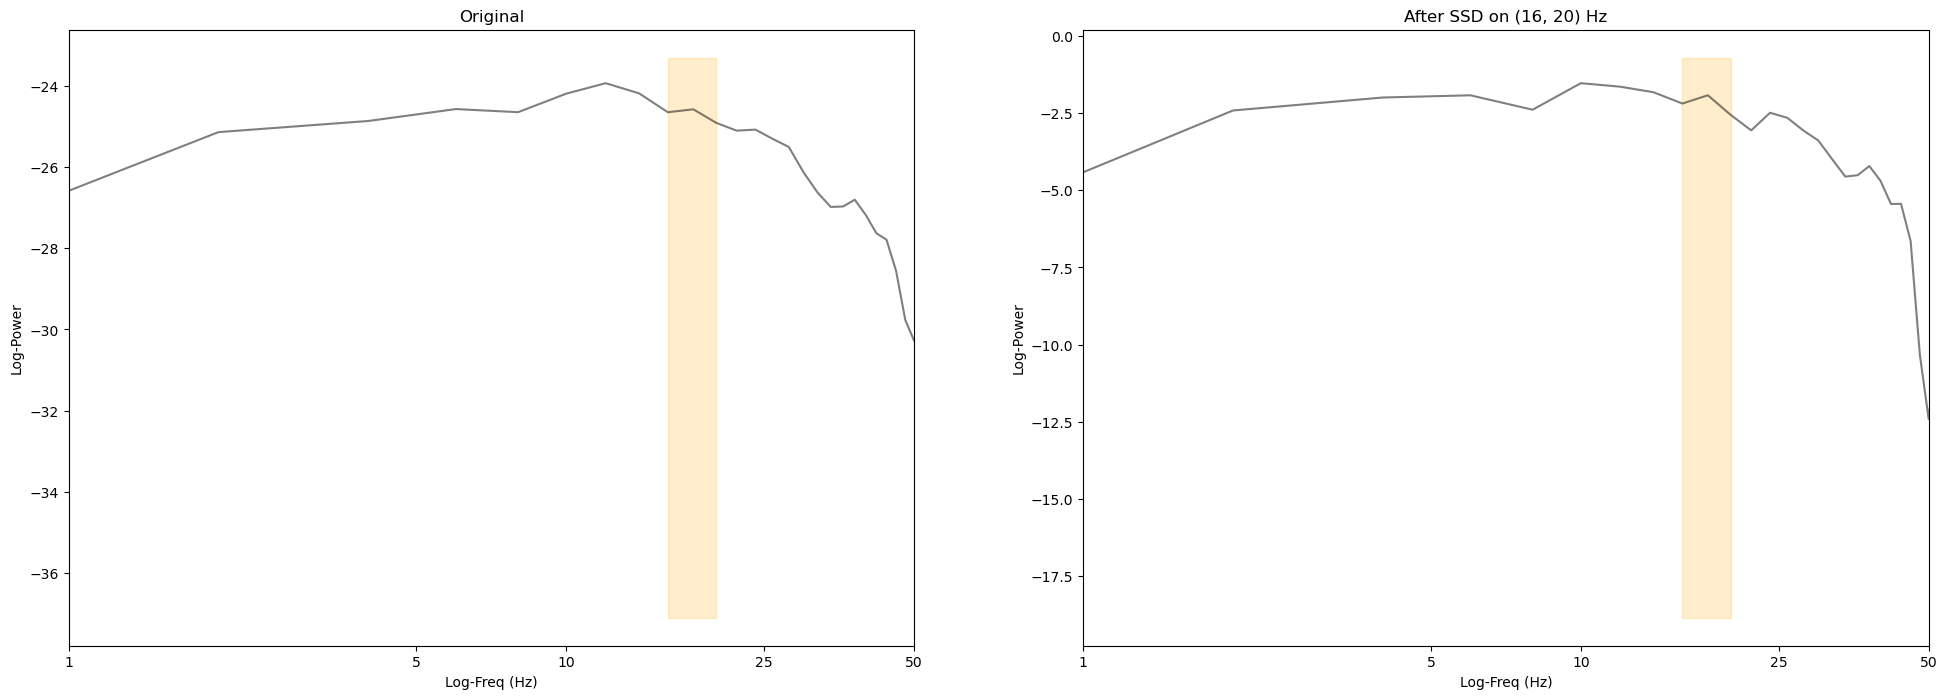

In [188]:
importlib.reload(specHelp)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

xlabels = [1, 5, 10, 25, 50, 75, 100, 200, 400]

freqs_ssd = (16, 20)
longsig = np.ravel(ch_wins[:20:2, :])
sig = np.ravel(ch_wins[18:20, :])

ssd_sig = longsig

f, Px = signal.welch(
    ssd_sig, fs=fs, nperseg=nperseg,
)
f[0] = 1
axes[0].plot(
        np.log(f), np.log(Px),
        alpha=.5, color='k',)
axes[0].set_xticks(np.log(xlabels))
axes[0].set_xticklabels(xlabels)
axes[0].set_xlabel('Log-Freq (Hz)')
axes[0].set_ylabel('Log-Power')
axes[0].set_xlim(0, np.log(50))

axes[0].set_title('Original')

# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=ssd_sig, fs=fs,
    freqband_to_optim=freqs_ssd
)
print(ssd_sources.shape)
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=fs, n_fft=1024)

freqs[0] = 1
axes[1].plot(
    np.log(freqs), np.log(np.ravel(psd)),
    alpha=.5, color='k',)
axes[1].set_xticks(np.log(xlabels))
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Log-Freq (Hz)')
axes[1].set_ylabel('Log-Power')
axes[1].set_xlim(0, np.log(50))

for ax in axes:
    ax.fill_betweenx(
        y=ax.get_ylim(),
        x1=np.log(freqs_ssd[0]), x2=np.log(freqs_ssd[1]),
        color='orange', alpha=.2,)
axes[1].set_title(f'After SSD on {freqs_ssd} Hz')

plt.show()

## SPECTRAL features

get fooof running


selected ecog-channel: ECOG_L_1
selected stn-channel: LFP_L_0_1
Total time UP + DOWN: 0.62 sec
Peak frequencies:
Beta ([13, 30] Hz) peak: 17.5 Hz
Gamma ([60, 90]) peak: 85.8 Hz
Local peak heights:
Beta: 2.0678798673600234,
Gamma: 2.6860669038169434


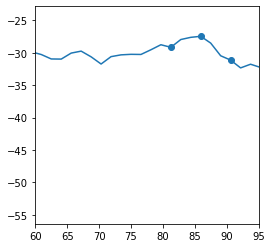

In [ ]:
from fooof import FOOOF
fm = FOOOF()

# FOOOF peak definition -> MODULE
beta_range = [13, 30]
gamma_range = [60, 90]
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='fixed',
    verbose=False,
)
f_range = [3, 90]
fm.fit(fx, psd, f_range)
beta_f, beta_P, beta_w = get_band_peak_fm(fm, beta_range, select_highest=True)
gamma_f, gamma_P, gamma_w = get_band_peak_fm(fm, gamma_range, select_highest=True)
print(f'Peak frequencies:\nBeta ({beta_range} Hz) peak: '
    f'{np.round(beta_f, 1)} Hz\nGamma ({gamma_range}) peak: '
    f'{np.round(gamma_f, 1)} Hz')
# fm.plot()
# creating bandwidth around Gamma-peak
gamma_frange_psd = [
    np.argmin(abs(fx - (gamma_f - 5))),
    np.argmin(abs(fx - gamma_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (gamma_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
gamma_peak_height = logpsd[gamma_frange_psd[1]] - np.mean([
    logpsd[gamma_frange_psd[0]], logpsd[gamma_frange_psd[2]]
])
# creating bandwidth around Beta-peak
beta_frange_psd = [
    np.argmin(abs(fx - (beta_f - 5))),
    np.argmin(abs(fx - beta_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (beta_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
beta_peak_height = logpsd[beta_frange_psd[1]] - np.mean([
    logpsd[beta_frange_psd[0]], logpsd[beta_frange_psd[2]]
])
print(f'Local peak heights:\nBeta: {beta_peak_height},\n'
    f'Gamma: {gamma_peak_height}')

### PLOTTING
fig, ax  = plt.subplots(1,1, figsize=(4, 4))
ax.plot(fx, logpsd)
ax.set_xlim(60, 95)

ax.scatter(
    fx[gamma_frange_psd],
    logpsd[gamma_frange_psd]
)

plt.show()
## take psd plots from before
## 4d polynominal fit for gamma peak detect (also beta peak)
## beta-gamma power around peak
## coherence

### 2. Explore spectral domain: Try out wavelet

CH 1;	ephy_ch {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2} -> ECOG_L_1
Acc samples block 7: 210
CH 4;	ephy_ch {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2} -> LFP_L_3_4
Acc samples block 7: 210
CH 2;	ephy_ch {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2} -> LFP_R_3_4
Acc samples block 7: 210


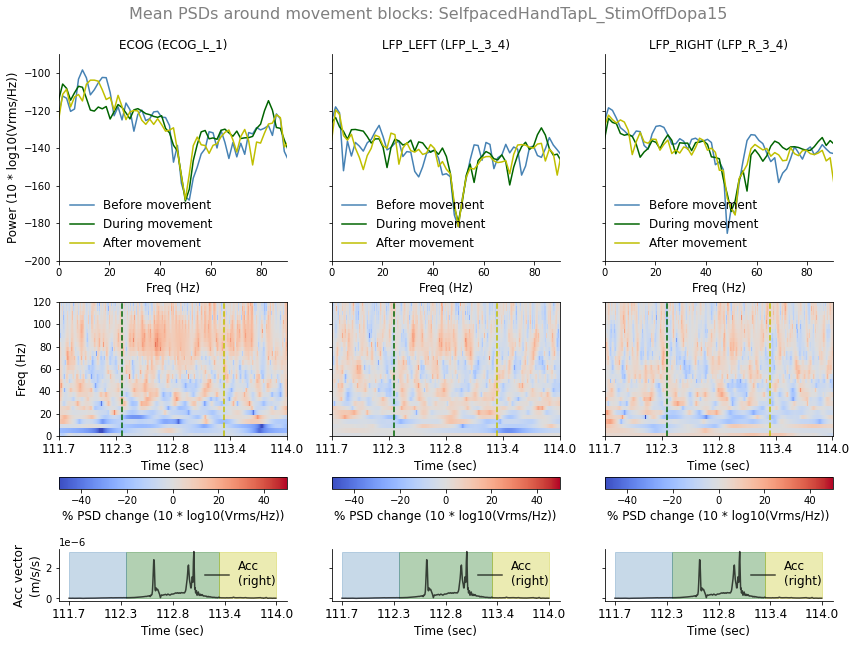

In [ ]:
fig, axes = plt.subplots(
    3, 3, figsize=(12, 9),
    sharey='row',
    gridspec_kw={'height_ratios': [4, 4, 1]})
ts=12
# levels with most beta/gamma roughly:
# ECOG 1; LFP_R: 2-3, 4-5; LFP_L: 1-2, 2-3, 3-4
ephy_ch = {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2}
nsegs = 512
halfseg  = nsegs // 2

runpsds = np.zeros((1, halfseg + 1))  # store ephys windows
prepsds = np.zeros((1, halfseg + 1))
postpsds = np.zeros((1, halfseg + 1))
accside = 'right'
# lfpside = 'lfp_left'
ephys_fs = getattr(SUB08.runs[SUB08.runs_incl[0]],
    f'ecog_Fs')
acc_fs = getattr(SUB08.runs[SUB08.runs_incl[0]],
    f'acc_{accside}_Fs')

accsegs = int(nsegs / ephys_fs * acc_fs)
runaccs = np.zeros((1, accsegs))  # store acc windows

clrs = {
    'Before': 'steelblue',
    'During': 'darkgreen',
    'After':'y'
}
fillparams = {
    'Before': {'color': 'none', 'hatch': '//',
            'edgecolor': clrs['Before'],'alpha': .8,},
    'During': {'color': clrs['During'], 'alpha': .1,},
    'After': {'color': 'none', 'hatch': '\\',
            'edgecolor': clrs['After'],'alpha': .8,},
}
run = 'SelfpacedHandTapL_StimOffDopa15'
for i in np.arange(10):
    for col, ephys in enumerate([
        'ecog',
        'lfp_left',
        'lfp_right'
    ]):
        RUN = SUB08.runs[run]
        ch = ephy_ch[ephys]
        chname = getattr(RUN,
            f'{ephys}_names')[ch]
        print(f'CH {ch};\tephy_ch {ephy_ch} -> {chname}')
        # epoch artefact baselines for run
        runmean = np.mean(getattr(RUN,
            f'{ephys}_arr')[ch, :])
        runstd = np.std(getattr(RUN,
            f'{ephys}_arr')[ch, :])
        SD4 = runmean + runstd * 4  # threshold sd4
        
        # calculate acc signal vector magn for run
        acc_svm = np.sqrt(
            getattr(RUN, f'acc_{accside}_arr')[1, :]**2 +
            getattr(RUN, f'acc_{accside}_arr')[2, :]**2 +
            getattr(RUN, f'acc_{accside}_arr')[3, :]**2
        )

        i = 7  # SELECT MOV-BLOCK TO PLOT

        print(f'Acc samples block {i}: {len(runblocks[run][accside][i])}')
        # take start (end) in Acc-blocks
        accstart = runblocks[run][f'{accside}'][i][0]
        # find corresponding timestamp in ephys
        ephystart = np.where(getattr(RUN, f'{ephys}_arr')[
            0, :] == accstart)[0][0]
        accend = runblocks[run][f'{accside}'][i][-1]
        ephyend = np.where(getattr(RUN, f'{ephys}_arr')[
            0, :] == accend)[0][0]
        blockacc = acc_svm[
            int(accstart * acc_fs) - accsegs:
            int(accend * acc_fs) + accsegs
        ]  # selects acc for mov block + segm pre/post
        movdat = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart:ephyend]
        predat = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart - nsegs:ephystart]
        postdat = getattr(RUN, f'{ephys}_arr')[
            ch, ephyend:ephyend + nsegs]
        wavdat = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart - nsegs:ephyend + nsegs]
        wavtime = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart - nsegs:ephyend + nsegs]
        # artefact check
        if np.any([
            np.any(movdat > SD4),
            np.any(postdat > SD4),
            np.any(predat > SD4),
        ]):
            print(f'ARTEFACT: Skip block {i} from '
                    f'{ephys} {run}')
            continue  # skip block

        fs, movpsd = signal.welch(
            movdat,
            fs=ephys_fs,
            nperseg=nsegs, noverlap=halfseg,  #axis=1,
        )  # create arr with welch-psd per window in block
        fs, prepsd = signal.welch(
            predat,
            fs=ephys_fs,
            nperseg=nsegs, noverlap=halfseg,
        )
        fs, postpsd = signal.welch(
            postdat,
            fs=ephys_fs,
            nperseg=nsegs, noverlap=halfseg,
        )

        ### Plot PSD of active blocks in Run
        for label, psd_arr in zip(
            ['Before', 'During', 'After'],
            [prepsd, movpsd, postpsd]  # removed 2d-psds
        ):
            axes[0, col].plot(
                fs, 10 * np.log10(psd_arr), label=f'{label} movement',
                c=clrs[label],
            )
        axes[0, col].set_xlabel('Freq (Hz)', size=ts,)
        if col == 0:
            axes[0, col].set_ylabel('Power (10 * log10(Vrms/Hz))', size=ts,)
        axes[0, col].set_xlim(0, 90)
        axes[0, col].set_ylim(-200, -90)
        axes[0, col].set_title(f'{ephys.upper()} ({chname})')
        axes[0, col].legend(
            ncol=1, frameon=False, loc='lower left', fontsize=ts,)
        axes[0, col].spines['right'].set_visible(False)
        axes[0, col].spines['top'].set_visible(False)

        ### Wavelet Decomposition
        w = 8  # depth/spaces?
        wav_f = np.linspace(1, ephys_fs / 2, 100)
        widths = (ephys_fs * w) / (2 * wav_f * np.pi)
        wav_t = np.arange(len(wavdat))
        scp_cfs = signal.cwt(
            wavdat, signal.morlet2, widths=widths,
            w=w, dtype='complex128'
        )
        wavpsd = np.abs(scp_cfs)
        logwavpsd = 10 * np.log10(wavpsd)
        ephybase = getattr(newbase, ephys)
        wavbase = 10 * getattr(ephybase, chname).wavlog['psd']
        wavpsd = logwavpsd - wavbase[:, :logwavpsd.shape[1]]  # absolute
        wavpsd = (wavpsd / np.abs(wavbase[:, :logwavpsd.shape[1]])) * 100  # %
        # Plot change vs base of time-spectral wavelet decomp
        im = axes[1, col].pcolormesh(
            wav_t, wav_f, wavpsd,
            cmap='coolwarm',
            # vmin=-5, vmax=5,  # absolute
            vmin=-50, vmax=50,  # percentage
        )
        cbar = fig.colorbar(
            im, ax=axes[1, col], 
            location='bottom', pad=.2,)
        cbar.set_label('% PSD change (10 * log10(Vrms/Hz))', size=ts,)
        # Plot details
        # axes[1, col].set_title(f'{ephys} psd change vs baseline')
        axes[1, col].set_ylim(0, 120)
        axes[1, col].set_xlabel('Time (sec)', size=ts,)
        axes[1, col].set_xticks(np.linspace(
            wav_t[0], wav_t[-1], 5
        ))
        axes[1, col].set_xticklabels(np.round(np.linspace(
            ephystart - nsegs, ephyend + nsegs, 5) / ephys_fs, 1),
            size=ts,)
        if col == 0: axes[1, col].set_ylabel('Freq (Hz)', size=ts,)
        # add Acc-line in Time-Freq plot
        axes[1, col].axvline(
            x=wav_t[nsegs], color=clrs['During'], ls='dashed',)
        axes[1, col].axvline(
            x=wav_t[-nsegs], color=clrs['After'], ls='dashed',)

        ### Plot mean signal vector for ACC
        axes[2, col].plot(
            np.arange(
                (accstart * acc_fs) - accsegs,
                (accend * acc_fs) + accsegs
            ), blockacc,
            label=f'Acc\n({accside})',
            c='k', alpha=.7,
        )
        maxsvm = np.max(blockacc)
        axes[2, col].fill_betweenx(
            y=np.linspace(0, maxsvm, 10),
            x1=accstart * acc_fs, x2=accend * acc_fs,
            color=clrs['During'], alpha=.3,
        )
        axes[2, col].fill_betweenx(
            y=np.linspace(0, maxsvm, 10),
            x1=accstart * acc_fs - accsegs,
            x2=accstart * acc_fs,
            color=clrs['Before'], alpha=.3,
        )
        axes[2, col].fill_betweenx(
            y=np.linspace(0, maxsvm, 10),
            x1=accend * acc_fs,
            x2=accend * acc_fs + accsegs,
            color=clrs['After'], alpha=.3,
        )

        xticks = np.linspace(
            (accstart * acc_fs) - accsegs,
            (accend * acc_fs) + accsegs, 5
        )
        axes[2, col].set_xticks(xticks)
        axes[2, col].set_xticklabels(
            np.round(xticks / acc_fs, 1),
            size=ts,)
        axes[2, col].set_xlabel('Time (sec)', size=ts,)
        if col == 0: axes[2, col].set_ylabel(
            'Acc vector\n(m/s/s)', size=ts,)
        axes[2, col].legend(
            ncol=1, frameon=False, loc='upper right', 
            # bbox_to_anchor=(0.8, -.05)
            fontsize=ts,
        )
        axes[2, col].spines['right'].set_visible(False)
        axes[2, col].spines['top'].set_visible(False)


    title = (f'Mean PSDs around movement blocks: {run}')
    plt.suptitle(title, size=16, x=.5, y=.99, c='gray')
    plt.tight_layout(h_pad=.3)
    fname = f'Mean_PSDs_aroundMov_EcogLfps_Ex_Dopa15_{i}_percCh2'
    fig.savefig(os.path.join(temp_save, fname),
        facecolor='white', dpi=150,)
    plt.close()

#


In [ ]:
print(accend, accstart)

113.37 112.325


In [ ]:
wav_t.shape[0] / 800

2.325

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_24487/64058387.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(fx), np.log10(psx))


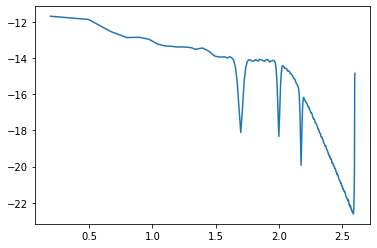

In [ ]:
fx, psx = signal.welch(
    SUB08.runs['Rest_StimOffDopa00'].lfp_left_arr[1][
        4000:52000],
    fs=SUB08.runs['Rest_StimOffDopa00'].lfp_left_Fs,
    nperseg=512, noverlap=256,
)
plt.plot(np.log10(fx), np.log10(psx))
# plt.xlim(0, 120)
plt.show()

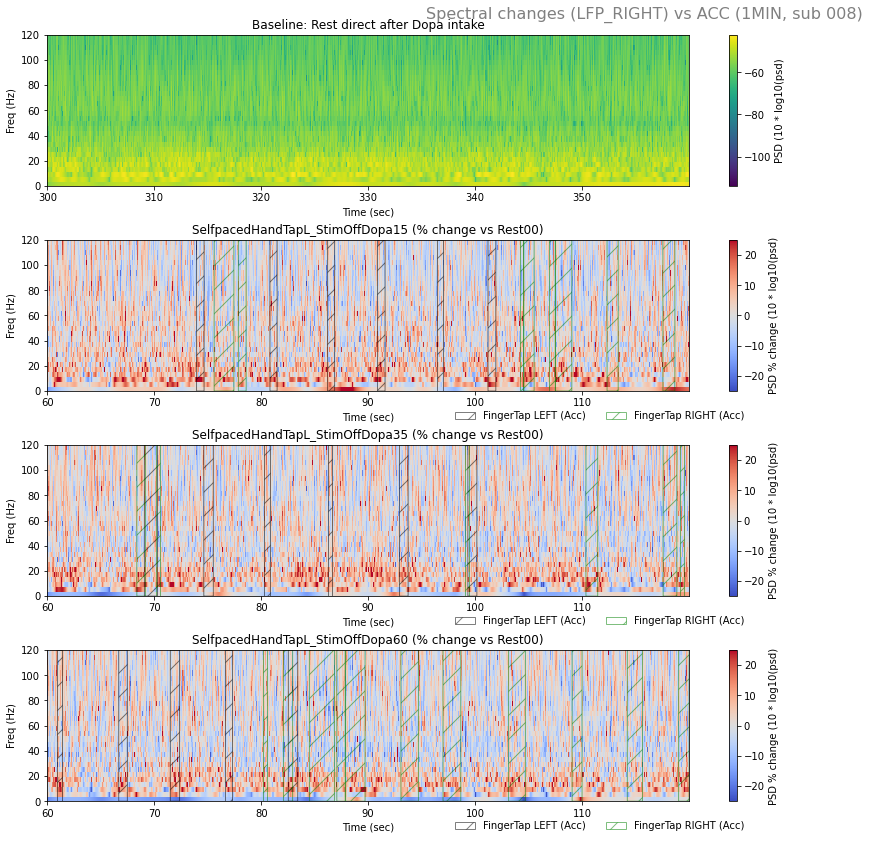

In [ ]:
'''
Plot BASE 00, then Selfp over time corrected for BASE
'''


plotruns = [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]
datasource = 'lfp_right'
clrs = {'left': 'k', 'right': 'green'}

fig, axes = plt.subplots(len(plotruns) + 1, 1, figsize=(12, 12))

base = SUB08.runs['Rest_StimOffDopa00']
Fs_lfp = getattr(base, f'{datasource}_Fs')
Fs_acc = base.acc_left_Fs
istart = 60 * Fs_lfp
istop = 120 * Fs_lfp

basestart = 300 * Fs_lfp  # first minute no rest
basestop = 360 * Fs_lfp
basetime = getattr(base, f'{datasource}_arr')[
    0, basestart:basestop]
basesig = getattr(base, f'{datasource}_arr')[
    1, basestart:basestop]

# Plot BASE
w = 8  # depth/spaces?
base_f = np.linspace(1, Fs_lfp / 2, 100)
widts = (Fs_lfp * w) / (2 * base_f * np.pi)
# mor = signal.morlet2(M=100, s=4, w=2)
scp_cfs = signal.cwt(
    basesig, signal.morlet2, widths=widts,
    w=w, dtype='complex128')
scp_psd = np.abs(scp_cfs)
baselogpsd = 10 * np.log10(scp_psd)

im = axes[0].pcolormesh(
    basetime, base_f, baselogpsd,
    cmap='viridis'
)
cbar = fig.colorbar(im, ax=axes[0], )
cbar.set_label('PSD (10 * log10(psd)')
axes[0].set_title('Baseline: Rest direct after Dopa intake')
axes[0].set_ylabel('Freq (Hz)')


# Plot Tap Runs
for ax, run in enumerate(plotruns):
    sig=getattr(SUB08.runs[run],
        f'{datasource}_arr')[1, istart:istop]
    time=getattr(SUB08.runs[run],
        f'{datasource}_arr')[0, istart:istop]

    # SCIPY WAVELET
    scp_cfs = signal.cwt(
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    logpsd = 10 * np.log10(scp_psd)
    changepsd = ((logpsd - baselogpsd) / baselogpsd) * 100

    im = axes[ax + 1].pcolormesh(
        time, base_f, changepsd,
        cmap='coolwarm', vmin=-25, vmax=25,
    )
    cbar = fig.colorbar(im, ax=axes[ax + 1], )
    cbar.set_label('PSD % change (10 * log10(psd)')

    axes[ax + 1].set_title(f'{run} (% change vs Rest00)')
    axes[ax + 1].set_ylabel('Freq (Hz)')

    if run in runblocks.keys():
        for side in ['left', 'right']:
            for movb in runblocks[run][side]:
                if movb == 0:
                    axes[ax + 1].fill_between(
                        y1=0,
                        y2=120,
                        x=time,
                        where=np.logical_and(
                            runblocks[run][side][movb][0] < time,
                            time < runblocks[run][side][movb][-1]),
                        color='none', alpha=.5, hatch='/',
                        edgecolor=clrs[side],
                        label = f'FingerTap {side.upper()} (Acc)',
                    )
                else:
                    axes[ax + 1].fill_between(
                        y1=0,
                        y2=120,
                        x=time,
                        where=np.logical_and(
                            runblocks[run][side][movb][0] < time,
                            time < runblocks[run][side][movb][-1]),
                        color='none', alpha=.5, hatch='/',
                        edgecolor=clrs[side],
                    )
        axes[ax + 1].legend(loc='upper right',
            bbox_to_anchor=(1.1, -.07),
            frameon=False, ncol=2,
        )
                

for ax in axes:
    ax.set_ylim(0, 120)
    ax.set_xlabel('Time (sec)')
fname = (f'Spectral changes ({datasource.upper()}) '
         f'vs ACC (1MIN, sub {SUB08.runs[run].sub})')
plt.suptitle(
    fname,
    color='gray', x=.75, y=.97, size=16)
plt.tight_layout(w_pad=.001, h_pad=.5)
plt.savefig(os.path.join(temp_save, fname),
    dpi=150, facecolor='w',)
plt.show()

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa60'
side = 'left'
taptimes_video[run][f'{side}_stamps']

[Timestamp('2021-11-15 12:33:40'),
 Timestamp('2021-11-15 12:33:46'),
 Timestamp('2021-11-15 12:33:51'),
 Timestamp('2021-11-15 12:33:56'),
 Timestamp('2021-11-15 12:34:01'),
 Timestamp('2021-11-15 12:34:05'),
 Timestamp('2021-11-15 12:34:10'),
 Timestamp('2021-11-15 12:34:15'),
 Timestamp('2021-11-15 12:34:21'),
 Timestamp('2021-11-15 12:34:25'),
 Timestamp('2021-11-15 12:34:31'),
 Timestamp('2021-11-15 12:34:36'),
 Timestamp('2021-11-15 12:34:42'),
 Timestamp('2021-11-15 12:34:47'),
 Timestamp('2021-11-15 12:34:52'),
 Timestamp('2021-11-15 12:34:58')]

In [ ]:
['',
 'SelfpacedHandTapL_StimOffDopa60',
 
 'SelfpacedHandTapL_StimOffDopa35',
 'SelfpacedHandTapL_StimOffDopa15']

In [ ]:
def wavelet_log(time, Fs, sig):
    '''
    Morlet Wavelet and returns
    logged values
    Input:
        - time: array with timesamples
        - Fs: sample freq
        - sig: 1d array of time series of interest
    Returns:
        - time: unchanged time
        - freqs: arr of freq bins
        - logpsd: calculated log-psd
    '''
    assert len(time) == len(sig), print(
        '\nERROR: Length of time and signal-array'
        ' for wavelet do not match\n###'
    )
    w = 8  # define number of depth/spaces
    freqs = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * freqs * np.pi)
    coefs = signal.cwt(  # wavelet coeff's
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    psd = np.abs(coefs)
    logpsd = np.log10(psd)

    return time, freqs, logpsd
    

Rest_StimOffDopa10 SelfpacedHandTapL_StimOffDopa15
Rest_StimOffDopa30 SelfpacedHandTapL_StimOffDopa35
Rest_StimOffDopa50 SelfpacedHandTapL_StimOffDopa60


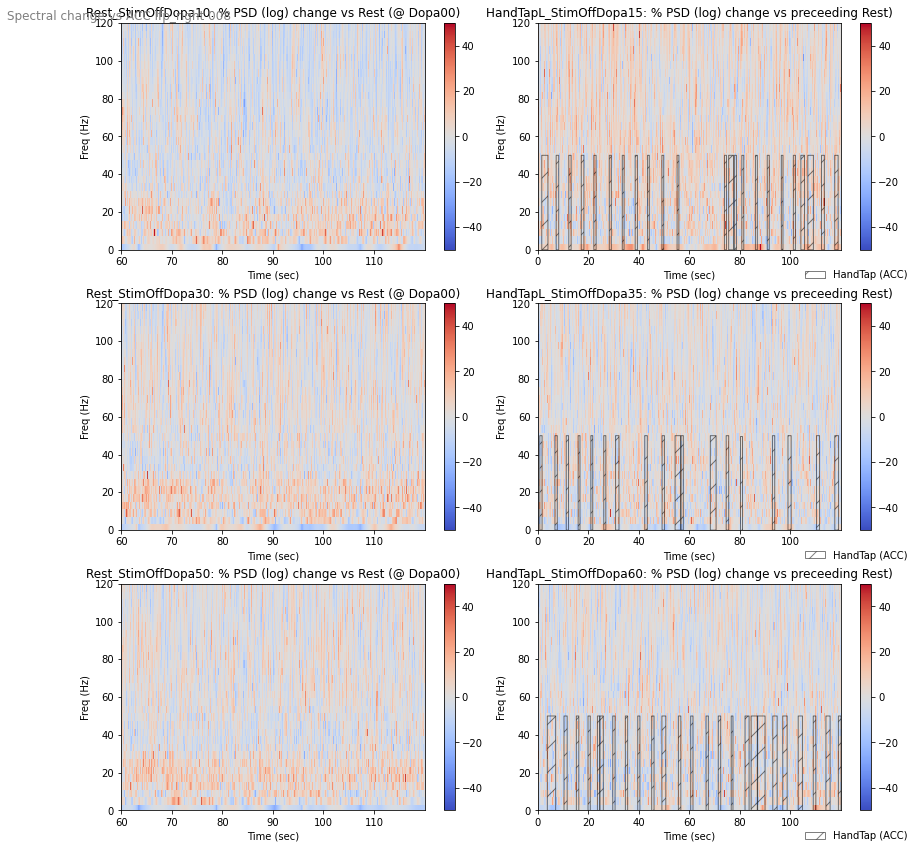

In [ ]:
'''
Rest spectral changes over time, and
handtapping compared to rest before'''

base00 = 'Rest_StimOffDopa00'
runcombis = (
    ('Rest_StimOffDopa10', 'SelfpacedHandTapL_StimOffDopa15'),
    ('Rest_StimOffDopa30', 'SelfpacedHandTapL_StimOffDopa35'),
    ('Rest_StimOffDopa50', 'SelfpacedHandTapL_StimOffDopa60'),
)
datsrc = 'lfp_right' # data source
lfprow=1

fig, axes = plt.subplots(len(runcombis), 2, figsize=(12, 12))

# Plot rest states
# define base settings
base = SUB08.runs[base00]
Fs_lfp = base.lfp_right_Fs
istart = 60 * Fs_lfp
istop = 60 * Fs_lfp * 2
# define base-psd
base_arr = getattr(base, f'{datsrc}_arr')[lfprow, istart:istop]
base_t = getattr(base, f'{datsrc}_arr')[0, istart:istop]
base_t, base_f, base_psd = wavelet_log(base_t, Fs_lfp, base_arr)
for row, restrun in enumerate(runcombis):
    # define Rest of Interest
    restrun = restrun[0]
    rest_arr = getattr(
        SUB08.runs[restrun], f'{datsrc}_arr')[lfprow, istart:istop]
    rest_t = getattr(
        SUB08.runs[restrun], f'{datsrc}_arr')[0, istart:istop]
    rest_t, rest_f, rest_psd = wavelet_log(rest_t, Fs_lfp, rest_arr)
    # Correct Rest-psd for Base-psd
    change_psd = rest_psd - base_psd  # calc change to Rest base00
    change_psd = (change_psd / base_psd) * 100  # calc in perc of base00
    # Plot wavelet psd
    im = axes[row, 0].pcolormesh(
        rest_t, rest_f, change_psd, cmap='coolwarm', vmin=-50, vmax=50,
    )
    fig.colorbar(im, ax=axes[row, 0], )
    axes[row, 0].set_title(f'{restrun}: % PSD (log) change vs Rest (@ Dopa00)')
    axes[row, 0].set_ylabel('Freq (Hz)')
    axes[row, 0].set_ylim(0, 120)
    axes[row, 0].set_xlabel('Time (sec)')


istart = 0 * Fs_lfp
istop = 60 * Fs_lfp * 2
# Plot Tap Runs
for row, runset in enumerate(runcombis):
    baserun, taprun = runset
    print(baserun, taprun)
    # Base
    base_arr = getattr(
        SUB08.runs[baserun], f'{datsrc}_arr')[lfprow, istart:istop]
    base_t = getattr(
        SUB08.runs[baserun], f'{datsrc}_arr')[0, istart:istop]
    base_t, base_f, base_psd = wavelet_log(base_t, Fs_lfp, base_arr)
    # Tap
    tap_arr = getattr(
        SUB08.runs[taprun], f'{datsrc}_arr')[lfprow, istart:istop]
    tap_t = getattr(
        SUB08.runs[taprun], f'{datsrc}_arr')[0, istart:istop]
    tap_t, tap_f, tap_psd = wavelet_log(tap_t, Fs_lfp, tap_arr)
    # Correct Rest-psd for Base-psd
    change_psd = tap_psd - base_psd  # calc change to Rest base00
    change_psd = (change_psd / base_psd) * 100  # calc in perc of base00
    # Plot
    im = axes[row, 1].pcolormesh(
        tap_t, tap_f, change_psd,
        cmap='coolwarm', vmin=-50, vmax=50,
    )
    fig.colorbar(im, ax=axes[row, 1], )

    axes[row, 1].set_title(f'{taprun[9:]}: % PSD (log) change vs preceeding Rest)')
    axes[row, 1].set_ylabel('Freq (Hz)')
    axes[row, 1].set_ylim(0, 120)
    # axes[row, 1].set_xlim(istart, istop)
    axes[row, 1].set_xlabel('Time (sec)')

    if taprun in runblocks.keys():
        for movb in runblocks[taprun]:
            axes[row, 1].fill_between(
                y1=0,
                y2=50,
                x=tap_t,
                where=np.logical_and(
                    runblocks[taprun][movb][0] < tap_t,
                    tap_t < runblocks[taprun][movb][-1]
                ),
                color='none', alpha=.5, hatch='/',
                edgecolor='k',
            )
            if movb == 0: axes[row, 1].legend(
                ['HandTap (ACC)'],
                loc='upper left',
                bbox_to_anchor=(.85, -.05),
                frameon=False,
            )

fname = (f'Spectral change vs ACC {datasource} '
         f'{SUB08.runs[taprun].sub}')
plt.suptitle(
    fname,
    color='gray', x=.05, y=.02,)
plt.tight_layout(pad=.5)
# plt.savefig(os.path.join(temp_save, fname),
#     dpi=150, facecolor='w',)
plt.show()





In [ ]:
SUB08.runs_incl

['Rest_StimOffDopa00',
 'SelfpacedHandTapL_StimOffDopa60',
 'Rest_StimOffDopa30',
 'SelfpacedHandTapL_StimOffDopa35',
 'Rest_StimOffDopa10',
 'Rest_StimOffDopa50',
 'SelfpacedHandTapL_StimOffDopa15']

In [ ]:
for movb in runblocks['SelfpacedHandTapL_StimOffDopa15']:
    print(runblocks['SelfpacedHandTapL_StimOffDopa15'][movb][0],
        runblocks['SelfpacedHandTapL_StimOffDopa15'][movb][-1],
        len(runblocks['SelfpacedHandTapL_StimOffDopa15'][movb]) / 200)

1.64 4.085 2.45
7.345 8.345 1.005
12.33 13.265 0.94
17.27 18.31 1.045
22.23 23.145 0.92
28.35 29.165 0.82
33.49 34.2 0.715
38.59 39.48 0.895
43.48 44.175 0.7
49.15 49.875 0.73
55.155 55.88 0.73
73.895 74.7 0.81
75.545 77.485 1.945
77.81 78.635 0.83
80.76 81.53 0.775
86.145 86.9 0.76
90.815 91.62 0.81
96.39 97.04 0.655
101.145 101.97 0.83
104.105 105.555 1.455
106.855 109.075 2.225
112.275 113.415 1.145
117.495 118.855 1.365
122.68 123.97 1.295
129.175 130.305 1.135
139.755 140.91 1.16
145.645 146.785 1.145
150.775 151.91 1.14
155.585 156.97 1.39
161.67 162.65 0.985
166.83 168.0 1.175
173.54 174.62 1.085
180.475 182.515 2.045
188.16 189.915 1.76
194.245 195.14 0.9
195.58 196.345 0.77


In [ ]:
importlib.reload(expl_plot)
expl_plot.electrode_spectral_check(
    sessionClass=SUB08,
    savedir=os.path.join(
        projectpath, 'figures', 'TEMP', 'spectral_tests'
    ),
    sides=['ecog', 'lfp_left'],  # add optionality for one column fig!
    fname_add='_RestMov_ECOG_welch' ,  #'_incl_Movem',
    tasks_incl=['Rest', 'Selfp'],  # has to be list (max first 5 letters)
    method='Welch',
)

'Figure saved!'

In [ ]:
ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
        sig,
        fs=Fs,
        freq_limits=[1, 120]  # [flim[0], flim[1]]
    )
    ghs_psd = np.abs(ghs_cfs)**2 / Fs
    # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
    ghs_psd /= np.max(ghs_psd)  # normalisation
    axes[0].pcolormesh(time, ghs_f, ghs_psd, cmap='viridis')
    axes[0].set_title('Ghostipy Cont. Wavelet Transform')

    # scipy CWT
    w = 8  # depth/spaces?
    scp_f = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * scp_f * np.pi)
    # mor = signal.morlet2(M=100, s=4, w=2)
    scp_cfs = signal.cwt(sig, signal.morlet2, widths=widts, w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    scp_psd /= np.max(scp_psd)  # normalisation
    axes[1].pcolormesh(time, scp_f, scp_psd, cmap='viridis')
    axes[1].set_title('SciPy Cont. Wavelet Transform')

    # scipy spectrogram
    npseg = 256
    fft_f, fft_t, fft_psd = signal.spectrogram(
        sig, fs=Fs, nperseg=npseg
    )  # or welch
    fft_t = time[(fft_t * len(time)).astype(int)]
    axes[2].pcolormesh(fft_t, fft_f, fft_psd)
    axes[2].set_title('SciPy Spectrogram (FFT)')

In [ ]:
g = 'lfp_left'
c = 2
chname = tempnms['00'][g][c]

data00 = tempdat['00'][g]
# data10 = tempdat['10'][g]
# data30 = tempdat['30'][g]
# data50 = tempdat['50'][g]
norm = 'std'

# for nrm in ['std', 'nrm', 'LOG']:
nrm = 'std'
for dff in ['minus', '%Change']:  # 
    plot_spectral_course(
        basedata=data00,
        dopa_data_dict=tempdat,
        dopa_names=tempnms['00'],
            dopa_keys=[ '50',],  #'10', '30',
            group=g,
            ch=c,
            norm=nrm,
            diff=dff,
        )


        ### WHY BETA INCREASE IN LOG VERSION??!!!


In [ ]:
def plot_spectral_course(
    basedata, dopa_data_dict, dopa_names, dopa_keys: list,
    group: str, ch: int, norm: str, diff: str,
):
    '''
    Plot spectral differences between session and baseline session.
    '''
    chname = dopa_names[group][ch]

    fig,axes = plt.subplots(
        len(dopa_keys), 3,
        sharey='row', sharex='col',
        figsize=(10, 6 * len(dopa_keys)))
    axes = axes.flatten()
    for row, dopaXX in enumerate(dopa_keys):
        dopadata = dopa_data_dict[dopaXX][group]

        for w in range(basedata.shape[0] // 10):
            d = np.hstack(basedata[w * 10:(w * 10) + 10, ch, :])
            f, t, ps = signal.spectrogram(
                d, fs=800, nperseg=256,
            )
            if w == 0:
                basepsd = np.empty((
                    basedata.shape[0] // 10,
                    len(f),
                    len(t),
                ))
            basepsd[w, :, :] = ps

        if nrm != 'LOG': basepsd = normalize(basepsd, norm)
        if nrm == 'LOG': basepsd = np.log(basepsd)
        basemean = np.nanmean(basepsd, axis=0)
        # Plot base (col-0)
        if nrm == 'LOG':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, basemean, cmap='viridis', vmin=-35, vmax=-30,)
        elif nrm == 'std':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, basemean, cmap='viridis', vmin=0, vmax=4,)
        else:
            im = axes[row * 3 + 0].pcolormesh(t, f, basemean, cmap='viridis')
        fig.colorbar(im, ax=axes[row * 3 + 0], )
        axes[row * 3 + 0].set_title('BASE')
        axes[row * 3 + 0].set_ylabel(f'Freq (Hz, {norm})')

        dopapsd = np.empty((
                    dopadata.shape[0] // 10,
                    len(f),
                    len(t),
                ))
        for w in range(dopapsd.shape[0]):
            d = np.hstack(dopadata[w * 10:(w * 10) + 10, ch, :])
            f, t, ps = signal.spectrogram(
                d, fs=800, nperseg=256)
            dopapsd[w, :, :] = ps
        if nrm != 'LOG': dopapsd = normalize(dopapsd, norm)
        if nrm == 'LOG': dopapsd = np.log(dopapsd)
        dopamean = np.nanmean(dopapsd, axis=0)
        # plot DOPA, col-1
        if nrm == 'LOG':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, dopamean, cmap='viridis', vmin=-35, vmax=-30,)
        elif nrm == 'std':
            im = axes[row * 3 + 1].pcolormesh(
                t, f, dopamean, cmap='viridis', vmin=0, vmax=4,)
        else:
            im = axes[row * 3 + 1].pcolormesh(t, f, dopamean, cmap='viridis')
        fig.colorbar(im, ax=axes[row * 3 + 1], )
        axes[row * 3 + 1].set_title(f'DOPA {dopa_keys[row]}')

        # DIFF
        if diff[0] == '%':  # define plot limits
            if nrm == 'LOG':
                powlims = (-5, 5)
            else:
                powlims = (-200, 200)
        elif nrm == 'LOG':
            powlims = (-1, 1)
        else:
            if norm == 'nrm':
                powlims = (-.1, .1)
            elif norm == 'std':
                powlims = (-3, 3)
        if diff == 'minus': psdiff = dopapsd - basemean
        if diff == '%Change': psdiff = ((dopapsd / basemean) * 100) - 100
        psdiff = np.nanmean(psdiff, axis=0)
        im = axes[row * 3 + 2].pcolormesh(t, f, psdiff,
            cmap='coolwarm', vmin=powlims[0], vmax=powlims[1])
        fig.colorbar(im, ax=axes[row * 3 + 2], )
        axes[row * 3 + 2].set_title(f'DIFF ({diff})')

        # all plots
        for ax in axes:
            ax.set_ylim(0, 100)
            ax.set_xlabel('Time (sec)')

    plt.suptitle(f'{RunInfo.store_str} ({group}: {chname})',
                c='gray', alpha=.5, y=.99, x=.4)
    plt.tight_layout(w_pad=.05)
    plt.savefig(os.path.join(spec_fig,
                f'SPEC_TEST_00vs{dopa_keys}_{norm}_{diff}'),
                facecolor='white', dpi=150)
    plt.close()


In [ ]:
pd.DataFrame(psdiff).describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,11.338391,230.777068,1.730689,-36.526793,25.217338,19.648497,9.333329,6.386118,1.136534,11.150465,...,-137.809805,8.493589,-1.575030,9.986192,13.849771,-65.049606,10.310639,-1.052715,-5.182092,10.754419
std,65.031270,1830.850918,46.137900,681.147310,119.234502,161.103864,64.829212,41.966471,72.460560,136.606070,...,1649.197910,61.878133,84.355342,66.570767,57.173457,893.983519,42.550590,98.878356,80.808166,57.111369
min,-214.746070,-175.174992,-233.425535,-7322.934606,-251.777062,-529.317798,-384.695062,-204.853201,-744.913064,-641.556306,...,-18717.328824,-244.786409,-609.266911,-470.858066,-214.815553,-10124.247438,-142.779837,-763.495852,-564.489765,-345.774088
25%,15.535429,14.562407,14.005507,15.451850,15.586630,15.837505,15.725187,15.680995,13.382596,14.749264,...,15.484896,14.861358,15.204023,15.384578,15.667523,15.740849,13.658483,15.030008,13.898907,15.742409
50%,15.890705,15.890651,15.890641,15.894880,15.890733,15.890734,15.890712,15.896433,15.890439,15.890519,...,15.890726,15.890569,15.890723,15.809812,15.890732,15.890733,15.800430,15.890689,15.890560,15.890723
75%,15.890755,15.890755,15.890755,15.895808,15.890755,15.890755,15.890755,15.898225,15.890755,15.890755,...,15.890755,15.890755,15.890755,15.856090,15.890755,15.890755,15.860461,15.890755,15.890755,15.890755
max,420.370039,17877.932533,153.251521,1937.059574,1071.750687,1678.177767,330.768509,117.748807,88.281555,1293.917125,...,126.798516,439.881128,103.218793,205.991854,349.876839,242.894342,209.298387,418.124020,137.557715,224.012386


In [ ]:
spec_fig = os.path.join(projectpath, 'figures', 'TEMP', 'spectral_tests')
os.mkdir(spec_fig)

In [ ]:
importlib.reload(expl_plot)
importlib.reload(fltrs)

Fs = 800

# Read in Preprocessed Data
for n in [7, 10]:  # fileDict
    RunInfo = dataMng.RunInfo(
        sub=fileDict[n]['sub'],
        ses=fileDict[n]['ses'],
        task=fileDict[n]['task'],
        acq=fileDict[n]['acq'],
        run=fileDict[n]['run'],
        raw_path='',
        project_path=fileDict[n]['projpath'],
        preproc_sett=fileDict[n]['version'],
    )
    print(f'start: {RunInfo.acq}')

# PM: change later fig-folder-structure
    data, names = dataMng.read_preprocessed_data(RunInfo)
    fig_path_expl = (f'{projectpath}/figures/exploration/'
                    f'sub-{RunInfo.sub}/{RunInfo.store_str}'
                    f'/{RunInfo.preproc_sett}')
    temp_save = f'{projectpath}/figures/TEMP/{RunInfo.store_str}'
    if not os.path.exists(temp_save): os.mkdir(temp_save)

    n_wins = 30

    mean=True
    diff=True

    # Plot Wavelet Decomp
    max_chs = max([data[g].shape[1] for g in data])  # largest ch-number
    fig, axes = plt.subplots(
        max_chs - 1, len(data), figsize=(12, 16), sharex='row',
        sharey='col',)
    for ax, g in enumerate(data):
        if g[-4:] != 'left': print('skip', g)
        if g[-4:] != 'left': continue
        for n, ch in enumerate(names[g][2:3]):  # select LESS CHANNELS FOR TIME
            if ch == 'time':
                print('skip time row')
                continue
            elif n in [1, 4, 5, 6]:
                print(ch,'skipped bcs of time')
                continue
            print('start',ax, g, n, ch)
            if mean:
                full_wins = data[g].shape[0] // n_wins
                for wstart in np.arange(full_wins):
                    sig = np.hstack(
                        data[g][n_wins * wstart:n_wins * (wstart + 1),
                                n,
                                :,]
                    )
                    ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                        sig,
                        fs=Fs,
                        freq_limits=[1,100],  # [flim[0], flim[1]]
                    )
                    ghs_psd = np.abs(ghs_cfs)**2 / Fs
                    ghs_psd /= np.max(ghs_psd)  # normalisation
                    if wstart == 0:  # create once 3d array to store psds
                        
                        psds = np.empty((full_wins,
                                         ghs_psd.shape[0],
                                         ghs_psd.shape[1]
                        ))
                        if RunInfo.acq[-2:] == '00':  # putted to hijack first win00 as base
                            print('defining baseline 00')
                            BASE_psd = ghs_psd.copy()
                            print(BASE_psd.shape)

                    psds[wstart, :, :] = ghs_psd  # one 2d array per 30-wins
                print('psds',psds.shape)
                if diff:
                    # if RunInfo.acq[-2:] == '00':  # DEFINE BASELINE
                    #     cfs_BASE, _, base_f, base_t, _ = gsp.cwt(
                    #         np.hstack(data[g][:, n, :])[:],
                    #         fs=Fs,
                    #         freq_limits=[1,100],
                    #     )
                    #     BASE_psd = np.abs(cfs_BASE)**2 / Fs
                    #     BASE_psd /= np.max(BASE_psd)
                        ### FIRST NORM AGAINST BASELINE, THEN AVERAGE WIN'S
                        # TODO: PLOT THE CHANGING REST FREQ'S OVER TIME,
                        # NORM AGAINST 30 SEC'S OF DOPA00
                        # THEN PLOT REST-CWT OVER TIME (PER 30 S, MEAN OVER 5 MINUTES?)
                    for w in range(psds.shape[0]):
                        psds[w, :, :] = (psds[w, :, :] / BASE_psd * 100) - 100  # extract the baseline cwt matrix
                        print('correct', ax, ch, w)
                        print(sum(sum(psds[w, :, :])))
                ghs_psd = np.nanmean(psds, axis=0)  # mean over all psd arrays
                print('psds new shape', ghs_psd.shape)
            else:
                sig = np.hstack(data[g][:n_wins, n, :])  # try out with 10 sec's
                ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                    sig,
                    fs=Fs,
                    freq_limits=[1,100]  # [flim[0], flim[1]]
                )
                ghs_psd = np.abs(ghs_cfs)**2 / Fs
                # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
                ghs_psd /= np.max(ghs_psd)  # normalisation
            
            # Plot
            colormap='viridis'
            if diff: colormap='coolwarm'
            im = axes[n - 1, ax].pcolormesh(
                ghs_t, ghs_f, ghs_psd, cmap=colormap, )  #vmin=-1, vmax=1,
            axes[n - 1, ax].set_title(ch)
            if ax == 0: axes[n - 1, ax].set_ylabel('Frequency (Hz)')
            fig.colorbar(im, ax=axes[n - 1, ax])
        axes[max_chs - 2, ax].set_xlabel('Time (sec)')
    plotname = f'{RunInfo.store_str}_({n_wins}_wins)'
    if mean: plotname = f'{RunInfo.store_str}_({n_wins}_wins_mean)'
    if diff: plotname += '_(%DIFF vs 3min-Dopa00)'
    print(f'saving {RunInfo.store_str}, name: {plotname}')
    plt.suptitle(f'Continuous Wavelet Transform (ghostipy): {plotname}',
                 size=14, x=.35, y=.99,)
    plt.tight_layout(h_pad=.05)
    
    plt.savefig(os.path.join(temp_save, f'CWT_{plotname}'),
                dpi=150, facecolor='white',)
    plt.close()


    # for nseg in [256, 512, ]:
    #     print('start ', nseg)
    #     expl_plot.meanPSDs_session_channels(
    #     data, names, norm='norm', nseg=nseg, RunInfo=RunInfo,
    #     save=temp_save, plot=False)

start: StimOffDopa00
skip ecog
start 1 lfp_left 0 LFP_L_1_2
(67, 24570)
psds (19, 67, 24570)
correct 1 LFP_L_1_2 0
correct 1 LFP_L_1_2 1
correct 1 LFP_L_1_2 2
correct 1 LFP_L_1_2 3
correct 1 LFP_L_1_2 4
correct 1 LFP_L_1_2 5
correct 1 LFP_L_1_2 6
correct 1 LFP_L_1_2 7
correct 1 LFP_L_1_2 8
correct 1 LFP_L_1_2 9
correct 1 LFP_L_1_2 10
correct 1 LFP_L_1_2 11
correct 1 LFP_L_1_2 12
correct 1 LFP_L_1_2 13
correct 1 LFP_L_1_2 14
correct 1 LFP_L_1_2 15
correct 1 LFP_L_1_2 16
correct 1 LFP_L_1_2 17
correct 1 LFP_L_1_2 18
psds new shape (67, 24570)
skip lfp_right
saving 008_EphysMedOn02_Rest_StimOffDopa00_1, name: 008_EphysMedOn02_Rest_StimOffDopa00_1_(30_wins_mean)_(%DIFF vs 3min-Dopa00)
start: StimOffDopa50
skip ecog
start 1 lfp_left 0 LFP_L_1_2
psds (8, 67, 24570)
correct 1 LFP_L_1_2 0
correct 1 LFP_L_1_2 1
correct 1 LFP_L_1_2 2
correct 1 LFP_L_1_2 3
correct 1 LFP_L_1_2 4
correct 1 LFP_L_1_2 5
correct 1 LFP_L_1_2 6
correct 1 LFP_L_1_2 7
psds new shape (67, 24570)
skip lfp_right
saving 008_E

In [ ]:
for g in data:
    print(g, 'start highpass 60')
    data[g] = fltrs.bp_filter(
        data[g],
        sfreq=800,
        l_freq=60,
        h_freq=None,)
    print(g, 'start low pass 90')
    data[g] = fltrs.bp_filter(
        data[g],
        sfreq=800,
        l_freq=None,
        h_freq=90,)

In [ ]:
# import single data file
sub = '009'
ses = 'EcogLfpMedOn02'
task = 'Rest'
acq = 'StimOff'
run = '01'
raw_path = ''
project_path = projectpath
sett_version = 'v0.4_Feb22'

In [ ]:
importlib.reload(dataMng)
runInfo = dataMng.RunInfo(
    sub, ses, task, acq, run,
    raw_path, project_path, sett_version,
)

### TODO: CHANGE FIG + DATA PATHS IN PREPROCESS FIG AND DATA
levdata, levnames = dataMng.read_preprocessed_data(runInfoLevels)
# make data class (data, names, fig_path)

In [ ]:
importlib.reload(dataMng)
importlib.reload(expl_plot)


for n in fileDict:
    RunInfo = dataMng.RunInfo(
        sub=fileDict[n]['sub'],
        ses=fileDict[n]['ses'],
        task=fileDict[n]['task'],
        acq=fileDict[n]['acq'],
        run=fileDict[n]['run'],
        raw_path='',
        project_path=fileDict[n]['projpath'],
        preproc_sett=fileDict[n]['version'],
    )
    print(f'\nSTART: {RunInfo.store_str}\n')

# PM: change later fig-folder-structure
    data, names = dataMng.read_preprocessed_data(RunInfo)
    fig_path_expl = (f'{projectpath}/figures/exploration/'
                    f'sub-{RunInfo.sub}/{RunInfo.store_str}'
                    f'/{RunInfo.preproc_sett}')
    # Plot
    for nseg in [256, 512, 800]:
        expl_plot.meanPSDs_session_channels(
        data, names, norm='norm', nseg=nseg, RunInfo=RunInfo,
        save=fig_path_expl, plot=False)


START: 009_EcogLfpMedOn02_SelfpacedHandFlipL_StimOffDopa50_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_Free_StimOffDopa55_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_Rest_StimOffDopa65_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_SelfpacedHandFlipR_StimOffDopa70_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
STAR

work according to contacts; visualize different contacts (and sources) over time and states; then choose how to prceed

### py_neuromodulation functionality

In [ ]:
pn_stream = nm_BidsStream.BidsStream(PATH_RUN=pathrun,
    PATH_BIDS=pathbidsraw,
    PATH_OUT=pathout)
pn_stream.settings

## Spectral Exploration

In [ ]:
dat = data['ecog']
nms = names['ecog']
sig = dat[110, 3, :]
time = dat[110, 0, :]

In [ ]:
winsum = 5
np.arange(0, dat.shape[0] // winsum * winsum, winsum)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295])

In [ ]:
def time2spectral(
    data, method: str, Fs: int=800,
):
    '''Timeit cwt via scipy and ghostipy'''
    ch = 3

    if method == 'ghostipy':
        winsum = 5
        startw = np.arange(
            0,
            data.shape[0] // winsum * winsum,
            winsum
        )
        for n, w in enumerate(startw):
            sig = np.hstack((
                data[w:w + winsum, ch, :]
            ))

        # for w in np.arange(data.shape[0]):
        #     sig = data[w, ch, :]

            ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                sig,
                fs=Fs,
                freq_limits=[1, 120]  # [flim[0], flim[1]]
            )
            if w == 0:  # create empty array with nr new freqs
                specArr = np.zeros((  # 4-dimensional
                    data.shape[1] - 1,  # number of channels
                    data.shape[0] // winsum,  # windows
                    len(ghs_f),  # new freq's
                    ghs_cfs.shape[1],  # over time
                ))
            ghs_psd = np.abs(ghs_cfs)**2 / Fs
            specArr[ch, n, :, :] = ghs_psd
        

        

    return specArr, ghs_f

In [ ]:
spc3 = time2spectral(dat, method='ghostipy')
# one channel, 300 x 800 (5 min's) -> 8 min

In [ ]:
spc  # ch2 ecog
gf  # freqs


In [ ]:
time10 = np.hstack((dat[:10, 0, :]))
c2_10w = np.hstack((spc[2, :10, :, :]))

In [ ]:
def compareCWT(sig, time, Fs=800, flim=(4, 90)):

    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

    # ghostipy: https://github.com/kemerelab/ghostipy/blob/master/ghostipy/spectral/cwt.py
    # uses default Morse wavelet
    ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
        sig,
        fs=Fs,
        freq_limits=[1, 120]  # [flim[0], flim[1]]
    )
    ghs_psd = np.abs(ghs_cfs)**2 / Fs
    # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
    ghs_psd /= np.max(ghs_psd)  # normalisation
    axes[0].pcolormesh(time, ghs_f, ghs_psd, cmap='viridis')
    axes[0].set_title('Ghostipy Cont. Wavelet Transform')

    # scipy CWT

    w = 8  # depth/spaces?
    scp_f = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * scp_f * np.pi)
    # mor = signal.morlet2(M=100, s=4, w=2)
    scp_cfs = signal.cwt(sig, signal.morlet2, widths=widts, w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    scp_psd /= np.max(scp_psd)  # normalisation
    axes[1].pcolormesh(time, scp_f, scp_psd, cmap='viridis')
    axes[1].set_title('SciPy Cont. Wavelet Transform')

    # scipy spectrogram
    npseg = 256
    fft_f, fft_t, fft_psd = signal.spectrogram(
        sig, fs=Fs, nperseg=npseg
    )  # or welch
    fft_t = time[(fft_t * len(time)).astype(int)]
    axes[2].pcolormesh(fft_t, fft_f, fft_psd)
    axes[2].set_title('SciPy Spectrogram (FFT)')

    # plot makeup
    for ax in axes:
        ax.set_ylim(flim[0], flim[1])
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (sec)')

    plt.show()

    return ghs_psd, ghs_f, scp_psd, scp_f

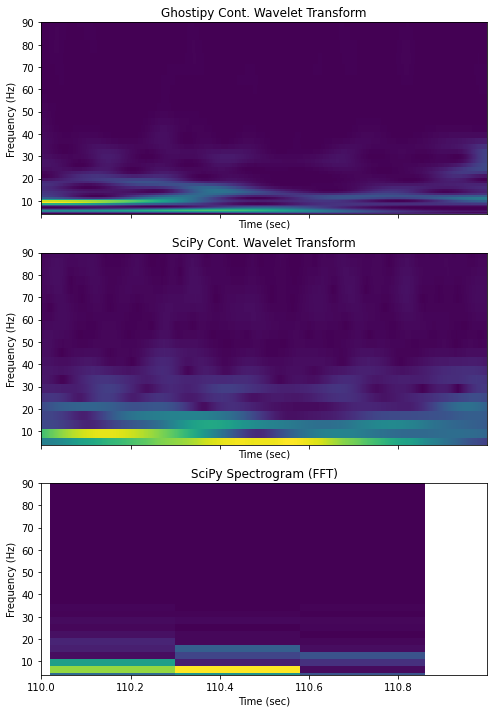

In [ ]:
sig = dat[110, 2, :]
gpsd, gf, scpsd, scf = compareCWT(sig, time)

START ecog with welch
START lfp_left with welch
START lfp_right with welch


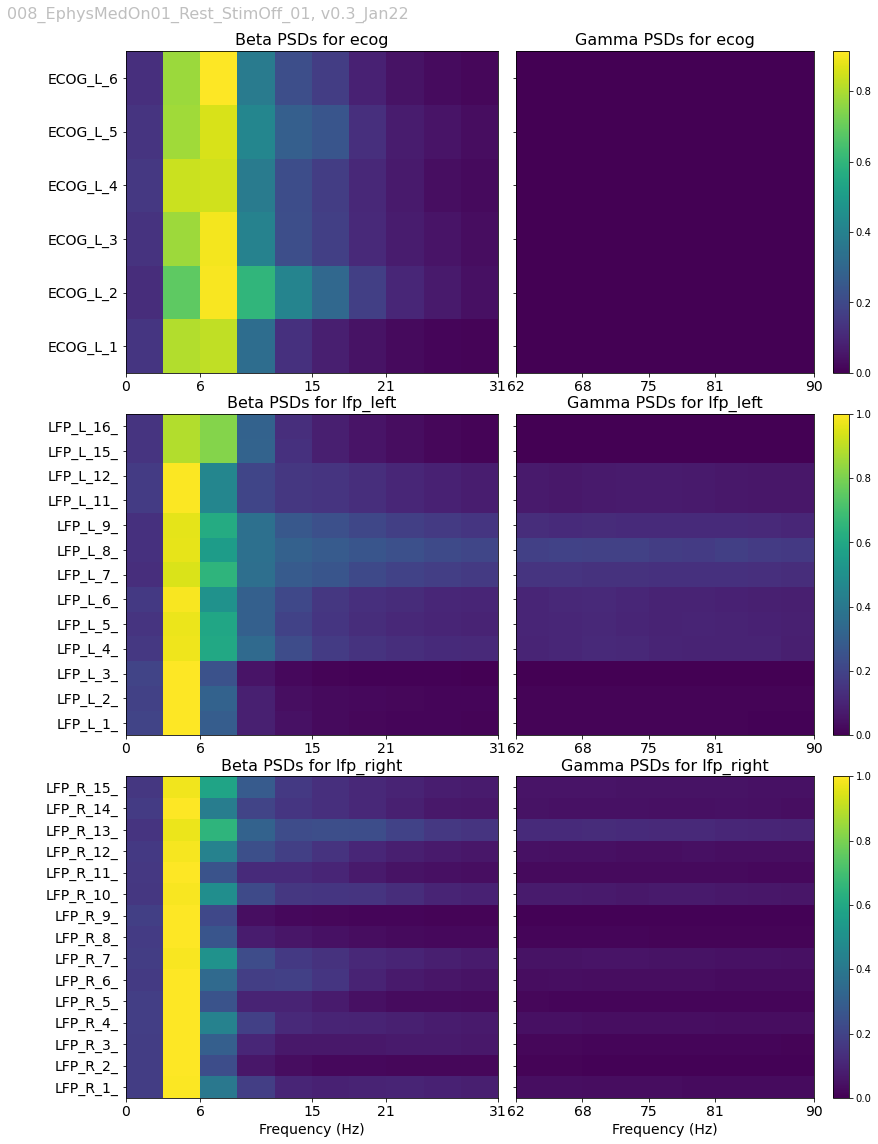

In [ ]:
# Plot PSD (beta-gamma) Channel-Overview per Session
expl_plot.meanPSDs_session_channels(
    data, names, norm='norm', nseg=256, RunInfo=runInfo,
    save=fig_path_seg)

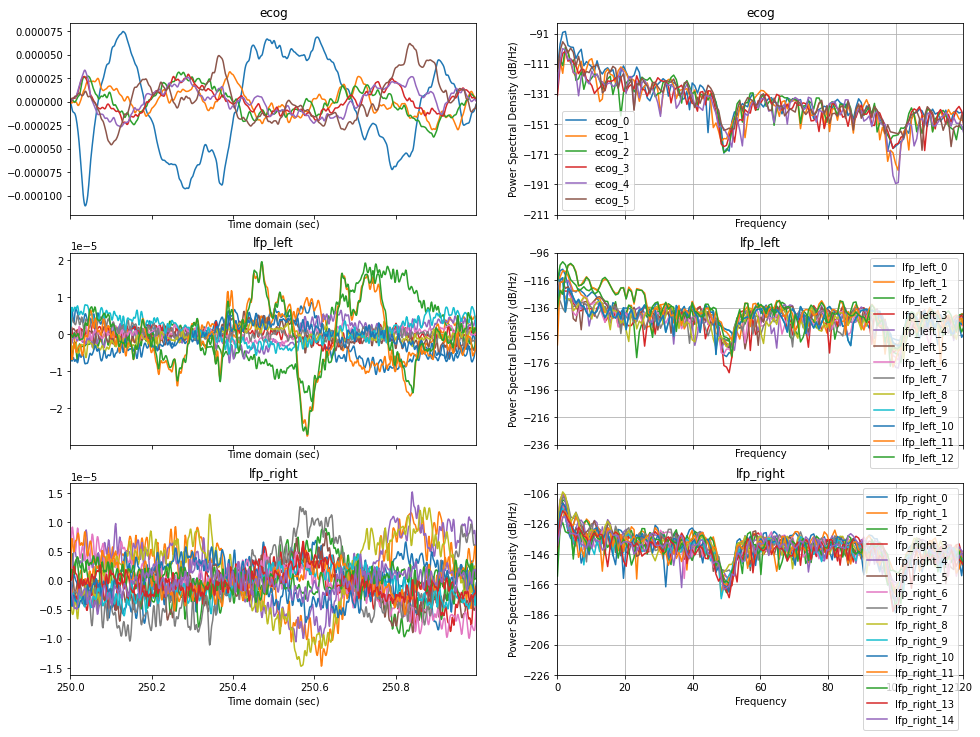

In [ ]:
fig, axes = plt.subplots(len(data), 2, sharex='col', figsize=(16,12))
w = 250
for n, g in enumerate(data):
    x = data[g][w, 0, :].T
    y = data[g][w, 1:, :].T
    # Raw
    axes[n, 0].plot(x, y)
    axes[n, 0].set_xlabel('Time domain (sec)')
    axes[n, 0].set_title(g)
    axes[n, 0].set_xlim(x[0], x[-1])
    # PSD
    for s in np.arange(y.shape[1]):
        axes[n, 1].psd(y[:, s], NFFT=1024, Fs=800, label=f'{g}_{s}')
    axes[n, 1].set_xlim(0, 120)
    axes[n, 1].set_title(g)
    axes[n, 1].legend()

plt.show()


### 2. Settings of Feature Extraction ??

In [ ]:
# APERIODIC EXPONENT
from fooof import FOOOF  # https://fooof-tools.github.io/fooof/

# cycle-by-cyle estimates
# neurodsp == 1.0.0  # install/import
# # neurodsp is a toolbox for digital signal processing for neural time series
# bycycle == 0.1.3  # install/import
# # bycycle is a toolbox for cycle-by-cycle analyses of neural oscillations

In [ ]:
## Wavelet Decomposition
power = mne.time_frequency.tfr_morlet(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles, 
    return_itc=False, 
    picks='ecog', 
    n_jobs=-1
)

(513,)
(1026,)
(4, 513)
(513,)


#### Pro Memori: Annotations and Events

In [ ]:
# check:
events, event_id = mne.events_from_annotations(raw, event_id={"EMG_onset": 1})
epochs = mne.Epochs(raw, events=events, tmin=-5, tmax=5, baseline=None)

#### - Feature extraction and visualization

In [ ]:
freqs = np.arange(1, 100)
n_cycles = 5

#### Pro Memori: Involve py_neuromodulation-functions in Signal Analysis